# **--- CNN MODEL ---** #

## **I. Libraries import** ##


In [85]:
import os
from pathlib import Path
import shutil
import zipfile
import requests
from tqdm import tqdm
import mlflow

# Torch ------------------
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models,datasets
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

# Metrics ------------------
from sklearn.metrics import f1_score, confusion_matrix

# Visualization ---------
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


from dotenv import load_dotenv 

load_dotenv()


True

We select the appropriate torch device

In [86]:
#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Apple M1/M2/M3
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device")

Using mps device


## **II. Images import** ##


### II.1. Extract images from Dataset and dataset refactoring

- function to clean data
- function to reorganize directories (eg: data/train instead of data/train/train)

In [87]:
def reorganize_dataset_dir(dest_data_dir:str)->list:
    '''
        Réorganise le dataset :
          - normalisation et renommage des noms des classes
          - suppression du doublonnage des répertoires
        Input
        - dest_data_dir : le répertoire destination contenant l'extraction du zip du dataset
        Output
        - renvoie les liste des labels du dataset sous sa forme normalisée
    '''
    labels = set()
    for split in ['train','test']:
        # on parcourt le dataset avec le pb data/train/train ou data/test/test
        data_root_path = Path(f'{dest_data_dir}/{split}/{split}')
        if data_root_path.exists() and data_root_path.is_dir():
            for dir_label in data_root_path.iterdir():
                # normalisation des noms de répertoire qui seront les noms des classes
                print(f"dir_label={dir_label}")
                new_label = dir_label.name.replace('Grape ','') \
                    .replace(' leaf','') \
                    .replace('_leaf','') \
                    .replace(' disease','') \
                    .replace(' ','_') \
                    .lower()
                labels.add(new_label)

                # on renomme les répertoires qui sont les noms des classes
                new_dir_label = dir_label.parent / new_label
                if not new_dir_label.exists():
                    try:
                        shutil.move(str(dir_label), str(new_dir_label))
                    except Exception as e:
                        print(f'Erreur renaming {dir_label} to {new_dir_label}')
                else:
                    print(f'{new_dir_label} already exists, ignored...')
            
            # on enlève la redondance split/split des répertoires
            print(f'Remove directory redundancy...')
            try:
                tmp_dir = f'{dest_data_dir}/{split}__'
                print(f'move from {data_root_path} to {tmp_dir}')
                shutil.move(str(data_root_path), tmp_dir) # on renomme en data/train/train__
                print(f'delete {str(data_root_path.parent)}')
                shutil.rmtree(str(data_root_path.parent)) # on supprime data/train
                print(f'move from {tmp_dir} to {dest_data_dir}/{split}')
                shutil.move(tmp_dir, f'{dest_data_dir}/{split}') # on renomme le data/train_ en data/train
            except Exception as e:
                print(f'Erreur moving {data_root_path} to {dest_data_dir} : {e}')
    return list(labels)

def clean_datadir(data_dir:str)->None:
    '''
        Supprime les répertoire train et test d'un répertoire de dataset
    '''
    dir_to_delete = [ f'{data_dir}/train', f'{data_dir}/test', f'{data_dir}/train__', f'{data_dir}/test__' ]
    for d in dir_to_delete:
        try:
            shutil.rmtree(d)
        except Exception as e:
            print(f'Erreur impossible to remove {d}')


- clean data if necessary

In [88]:
data_dir = '../data'
clean_datadir(data_dir)

Erreur impossible to remove ../data/train__
Erreur impossible to remove ../data/test__


- If not already downloaded, get dataset ZIP file from Kaggle...

In [89]:
# Possible to download manually the Kaggle dataset with curl
#
# curl -L -o ~/Downloads/grapes-leafs-disease-7-classes-plantcity-2025.zip\
#  https://www.kaggle.com/api/v1/datasets/download/codewithsk/grapes-leafs-disease-7-classes-plantcity-2025
#
url = "https://www.kaggle.com/api/v1/datasets/download/codewithsk/grapes-leafs-disease-7-classes-plantcity-2025"

data_zip_path = f'{data_dir}/grapes-leafs-disease-7-classes-plantcity-2025.zip'
#data_zip = f"{data_dir}/dataset_zip_test.zip" # pour tests et DEBUG

# Check if file already exists
if os.path.exists(data_zip_path):
    print(f"File already exists: {data_zip_path}")
    print("Skipping download.")
else:
    print(f"Downloading dataset to {data_zip_path}...")
    
    # Download with progress bar
    response = requests.get(url, stream=True, allow_redirects=True)
    response.raise_for_status()
    
    # Get total file size
    total_size = int(response.headers.get('content-length', 0))
    
    # Download with progress bar
    with open(data_zip_path, 'wb') as file, tqdm(
        desc=data_zip_path,
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=8192):
            size = file.write(chunk)
            bar.update(size)
    
    print(f"Download complete: {data_zip_path}")

File already exists: ../data/grapes-leafs-disease-7-classes-plantcity-2025.zip
Skipping download.


In [90]:
# on vérifier si le zip a déjà été dézippé
if not os.path.exists(f'{data_dir}/train/train') or not os.path.exists(f'{data_dir}/test/test'):
    # s'il reste des choses on supprime tout
    clean_datadir(data_dir)

    # extraction du zip
    print(f'Extract {data_zip_path} ...')
    with zipfile.ZipFile(data_zip_path, "r") as zip_ref:
        zip_ref.extractall(data_dir)
    
    # réorganisation du dataset
    labels = reorganize_dataset_dir(data_dir)
    print(labels)
else:
    print(f'{data_zip_path} already extracted, ignored...')


Erreur impossible to remove ../data/train
Erreur impossible to remove ../data/test
Erreur impossible to remove ../data/train__
Erreur impossible to remove ../data/test__
Extract ../data/grapes-leafs-disease-7-classes-plantcity-2025.zip ...
dir_label=../data/train/train/Grape shot hole leaf disease
dir_label=../data/train/train/Grape Downy mildew leaf
dir_label=../data/train/train/Grape Normal_leaf
dir_label=../data/train/train/Grape Brown spot leaf
dir_label=../data/train/train/Grape Anthracnose leaf
dir_label=../data/train/train/Grape Mites_leaf disease
dir_label=../data/train/train/Grape Powdery_mildew leaf
Remove directory redundancy...
move from ../data/train/train to ../data/train__
delete ../data/train
move from ../data/train__ to ../data/train
dir_label=../data/test/test/Grape shot hole leaf disease
dir_label=../data/test/test/Grape Downy mildew leaf
dir_label=../data/test/test/Grape Normal_leaf
dir_label=../data/test/test/Grape Brown spot leaf
dir_label=../data/test/test/Grape 

### II.2. Image viewing

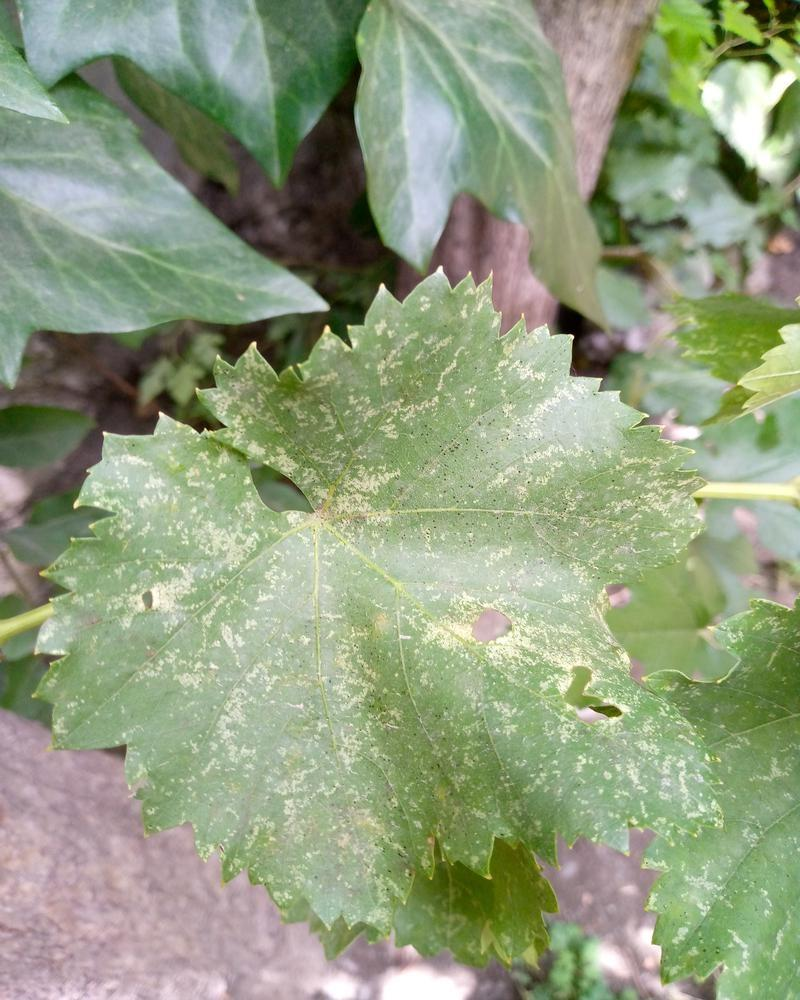

In [91]:
img = Image.open(f"{data_dir}/train/anthracnose/1.jpg")
#img.show()
display(img)

## **III. Images processing** ##


### Pipeline for data transformation ###


The dataset already contains pictures that have been flipped horizontaly, verticaly and randomly rotated. We need to resize the pictures to the size required by the Resnet Model (224,224).

In [92]:
# Définir les transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionnement à 224x224
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),          # Conversion en tenseur
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # Normalisation avec les valeurs du modèle pré-entraîné Resnet
])

### Load dataset ###


Our dataset is already divided into a train and a test set. We are going to extract 20% of the training set to create the validation set.

In [93]:
# Create the path to the training dataset
data_root = Path(f"{data_dir}/train")

# Load dataset with ImageFolder
dataset_train_folder = ImageFolder(root=data_root, transform=transform)

# Get class names
class_names = dataset_train_folder.classes

# Define the set size
train_size = int(0.8 * len(dataset_train_folder))
val_size = len(dataset_train_folder)-train_size

# We split our initial train dataset into the final train dataset (80%) and the validation dataset (20%)
train_dataset, val_dataset = torch.utils.data.random_split(dataset_train_folder, [train_size, val_size])


In [94]:
# Create the path to the training dataset
data_root_test = Path(f"{data_dir}/test")

# Load dataset with ImageFolder
test_dataset = ImageFolder(root=data_root_test, transform=transform)
test_size=int(len(test_dataset))

In [95]:
class_names

['anthracnose',
 'brown_spot',
 'downy_mildew',
 'mites',
 'normal',
 'powdery_mildew',
 'shot_hole']

In [96]:
nb_classes = len(dataset_train_folder.classes)
nb_classes

7

In [97]:
print(f"- Train dataset size : {train_size} ({train_size/(train_size+val_size+test_size)*100:.1f}% of the total amount of pictures)")
print(f"- Validation dataset size :  {val_size} ({val_size/(train_size+val_size+test_size)*100:.1f}% of the total amount of pictures)")
print(f"- Test dataset size :  {test_size} ({test_size/(train_size+val_size+test_size)*100:.1f}% of the total amount of pictures)")

- Train dataset size : 5044 (64.0% of the total amount of pictures)
- Validation dataset size :  1261 (16.0% of the total amount of pictures)
- Test dataset size :  1575 (20.0% of the total amount of pictures)


In [98]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

###---------------------------------
Si on a le temps :  on peut faire une classe maladie avec toutes les maladies regroupées pour faire un test sain/malade (dans ce cas là on pourra faire une classe personnalisée avec Pytorch dataset et créer le dataset en utilisant cette classe)
---------------------------------------###

Visualisation of a batch

Label : brown_spot


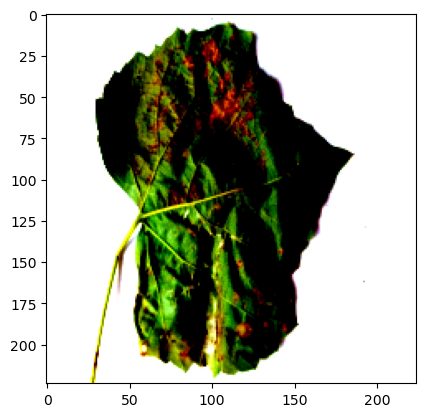

Label : shot_hole


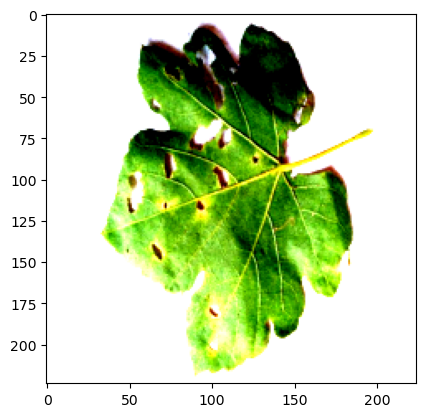

Label : normal


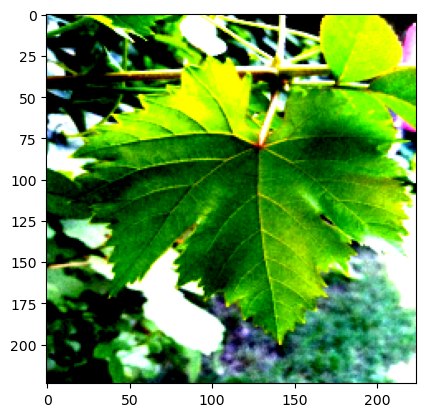

Label : powdery_mildew


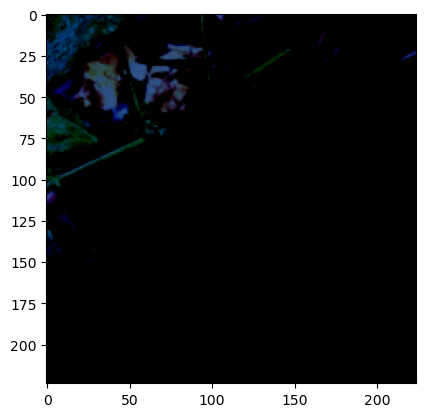

Label : shot_hole


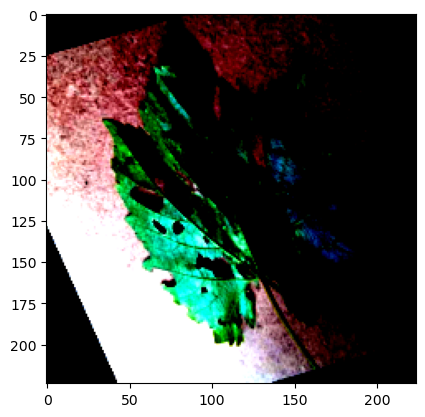

Label : brown_spot


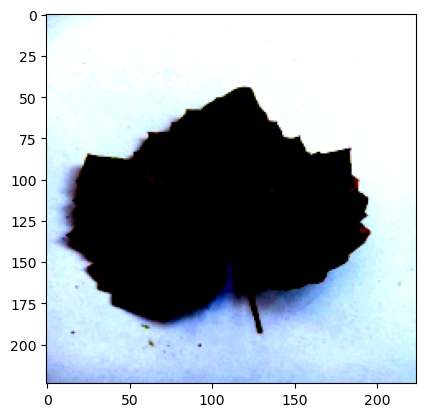

Label : shot_hole


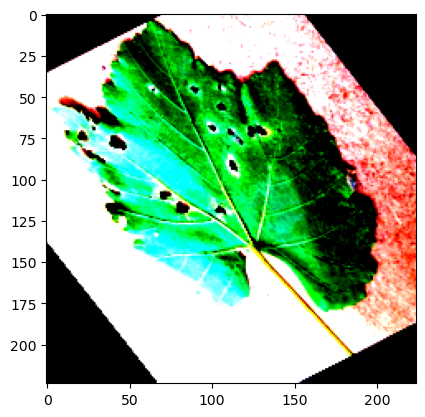

Label : normal


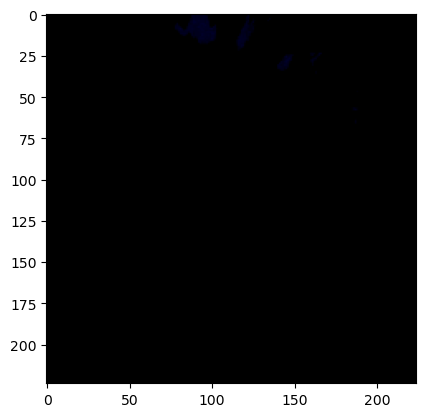

Label : powdery_mildew


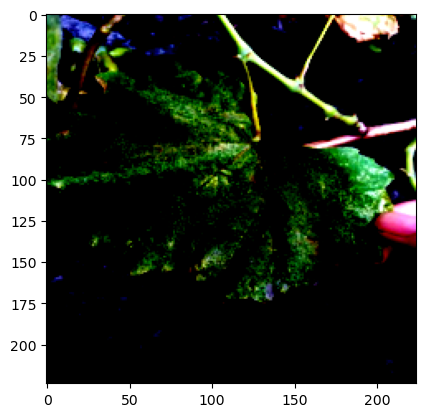

Label : powdery_mildew


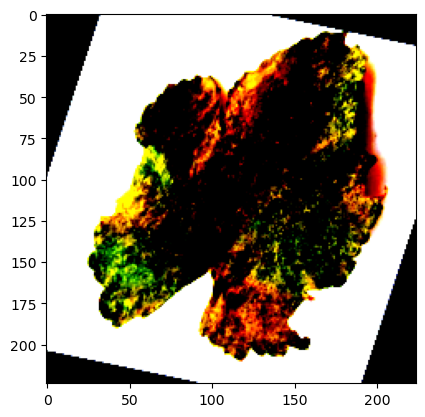

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

imgs, labels = next(iter(train_loader))
for i, (img, label) in enumerate(zip(imgs, labels)):
  true_label_name = class_names[label]
  print("Label :", true_label_name)
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.show()
  if i==9: break

## **Transfert learning (Resnet18)** ##

### Preparing the MLFlow tracking ###

In [100]:
# Set tracking URI to your Hugging Face application
MLFLOW_URI=os.getenv('MLFLOW_URI',"https://gviel-mlflow37.hf.space/")
mlflow.set_tracking_uri(os.environ["MLFLOW_URI"])

# Set experiment's info
EXPERIMENT_NAME= os.getenv('EXPERIMENT_NAME',"Vitiscan_CNN_MLFlow")
mlflow.set_experiment(EXPERIMENT_NAME)

# Get our experiment info
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

### Importing a pre-trained model

In [101]:
#model = models.resnet18(pretrained=True) # pour version <0.13.0
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # pour version >=0.13.0
model = model.to(device)
print(f"Model device: {next(model.parameters()).device}")
print(device)

Model device: mps:0
mps


In [102]:
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### Replace classification layer to adapt the model to our features ###

In [103]:
model.fc = nn.Linear(model.fc.in_features, nb_classes)


### Freeze the feature extraction layers ###

In [104]:
# We freeze all the convolutional layers
for param in model.parameters():
    param.requires_grad = False

# We unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True



In [105]:
# Print model summary
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

- **we can notice that we can train only 3,591 params instead of 11,689,512 initially**

### Adapting the model to the dataset ###

In [106]:
train_dataset.dataset.classes

['anthracnose',
 'brown_spot',
 'downy_mildew',
 'mites',
 'normal',
 'powdery_mildew',
 'shot_hole']

### Defining the cost function and optimizer ###

In [107]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # Move loss function to MPS

learning_rate=0.0005
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

### Train the model ###

We check an output on the fist batch

In [108]:
# Model outputs
image, label = next(iter(train_loader))
image=image.to(device)
model=model.to(device)
logit= model(image) # Resnet18 output
logit
# Attention il faut que l'image et le model aient le même device

tensor([[-0.2228,  0.3556, -0.6213,  0.8800, -0.0586, -0.7343, -0.6569],
        [ 0.0945,  0.3804,  0.5632,  0.4083, -0.2765,  0.0491, -0.8435],
        [-0.6414,  0.8621,  0.2947, -0.1899, -0.5859, -0.7852, -0.2644],
        [ 0.0075, -0.1694, -0.1539,  0.5149,  0.1471, -0.5092, -0.4419],
        [-1.1686,  0.1420,  0.2235,  0.0921, -0.3104,  0.4610, -0.3595],
        [-0.5198,  0.1467, -0.2471,  0.3307, -0.1985,  0.0111, -0.0121],
        [ 0.0679,  0.5699,  0.2046,  0.0717, -0.4908, -0.6545, -0.8219],
        [-0.0319,  0.2822,  0.7347,  0.0476, -0.2376,  0.1896, -0.7179],
        [-0.2461,  0.4070, -0.7832,  0.4486, -0.6373, -0.1463, -0.5996],
        [ 0.4032,  0.9161,  0.4639,  0.7735,  0.1773,  0.3996, -0.8138],
        [-0.0996,  1.1259,  0.5284, -0.0085, -0.2296,  0.5367, -1.2162],
        [-0.0415,  0.3362, -0.1104,  0.1767,  0.1200,  0.4788, -0.1954],
        [-0.7192,  0.8019,  0.2543,  0.1760,  0.2205, -0.8437, -0.9914],
        [-0.3806, -0.0260,  0.0484,  0.0671, -0.188

In [109]:
# # Training function for a PyTorch model
# def train(model, train_loader, val_loader, criterion, optimizer, epochs=1):
    
#     #  We start a MLFlow run
#     with mlflow.start_run(experiment_id = experiment.experiment_id):

#         # Logging Pytorch parameters into MLFlow 
#         params={
#             "optimizer": type(optimizer).__name__,
#             "learning_rate": optimizer.param_groups[0]['lr'],
#             "epochs": epochs,
#             "criterion": type(criterion).__name__,
#             "model_architecture": type(model).__name__,
#             "training_device": str(device)
#         }
#         mlflow.log_params(params=params)
#         mlflow.pytorch.autolog()

#         # Dictionary to store loss and accuracy values for each epoch
#         history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

#         # Loop through the specified number of epochs
#         for epoch in range(epochs):
#             model.train()  # Set model to training mode
#             total_loss, correct = 0, 0  # Initialize loss and correct predictions

#             # Training loop - iterate through batches in the training set
#             for images, labels in train_loader:
#                 images,labels = images.to(device),labels.to(device)
#                 optimizer.zero_grad()  # Reset gradients before each batch
#                 logit = model(images)  # Forward pass: Get predictions
#                 #probabilities = torch.softmax(logit, dim=1)  # [batch_size, 7]
#                 #predictions = torch.argmax(logit, dim=1)      # [batch_size]
#                 loss = criterion(logit, labels)  # Compute loss
#                 loss.backward()  # Backpropagation: Compute gradients
#                 optimizer.step()  # Update model parameters using optimizer

#                 total_loss += loss.item()  # Accumulate total loss
#                 #print("Logit : ",logit)
#                 #print("Label : ",label)
#                 #print("argmax(dim=1)",logit.argmax(dim=1))
#                 #print("Probability :",probabilities)
#                 #print("Prediction :",predictions)

#                 correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

#             # Compute average loss and accuracy for the training set
#             train_loss = total_loss / len(train_loader)
#             train_acc = correct / len(train_loader.dataset)

#             # Validation phase (no gradient calculation needed)
#             model.eval()  # Set model to evaluation mode
#             val_loss, val_correct = 0, 0
#             with torch.no_grad():  # Disable gradient calculation for efficiency
#                 for images, labels in val_loader:
#                     images,labels = images.to(device),labels.to(device)
#                     logit = model(images)  # A remonter à l'équipe Content, ne pas oublier d'ajouter le aux_logit
#                     #_, preds = torch.max(logit, 1) # extract predictions
#                     loss = criterion(logit, labels.data)  # Compute validation loss
#                     val_loss += loss.item()  # Accumulate validation loss
#                     val_correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

#             # Compute average loss and accuracy for the validation set
#             val_loss /= len(val_loader)
#             val_acc = val_correct / len(val_loader.dataset)

#             # Store training and validation metrics for analysis
#             history['loss'].append(train_loss)
#             history['val_loss'].append(val_loss)
#             history['accuracy'].append(train_acc)
#             history['val_accuracy'].append(val_acc)

#             # Print progress after each epoch
#             print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
#                 f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
#             # Logging metrics per epoch
#             mlflow.log_metric("train_loss", train_loss, step=epoch)
#             mlflow.log_metric("train_accuracy", train_acc, step=epoch)
#             mlflow.log_metric("validation_loss", val_loss, step=epoch)  
#             mlflow.log_metric("validation_accuracy", val_acc, step=epoch)
      
#         # Final metrics logging 
#         mlflow.log_metric("final_validation_accuracy", val_acc)
#         mlflow.log_metric("final_train_loss", train_loss)
        
#         # Model logging (Artifacts)
#         mlflow.pytorch.log_model(
#             pytorch_model=model, 
#             artifact_path="Resnet18",
#             registered_model_name=f"{params['model_architecture']}"
#         )
        
#         print("--- Metrics and model logged into MLFlow ---")

#         return history  # Return training history


    


In [110]:
def evaluate_model_on_test(model, test_loader, device):
    
    model.eval() # Mode évaluation
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logit = model(images)
            preds = logit.argmax(dim=1)
            
            # Compter l'exactitude
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
            # Collecter pour les métriques de Scikit-learn
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    test_accuracy = correct / total
    return test_accuracy, y_true, y_pred

In [ ]:
# Training function for a PyTorch model
def train(model, train_loader, val_loader,test_loader, criterion, optimizer, epochs=20):
    
    # We start a MLFlow run
    with mlflow.start_run(experiment_id = experiment.experiment_id):

        # Logging Pytorch parameters into MLFlow 
        params={
            "optimizer": type(optimizer).__name__,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "epochs": epochs,
            "criterion": type(criterion).__name__,
            "model_architecture": type(model).__name__,
            "training_device": str(device)
        }
        mlflow.log_params(params=params)
        mlflow.pytorch.autolog()

        # Dictionary to store loss and accuracy values for each epoch
        history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

        # Loop through the specified number of epochs
        for epoch in range(epochs):
            model.train()  # Set model to training mode
            total_loss, correct = 0, 0  

            # Training loop - iterate through batches in the training set
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad() 
                logit = model(images)  
                loss = criterion(logit, labels)  
                loss.backward()  
                optimizer.step()  

                total_loss += loss.item() 
                correct += (logit.argmax(dim=1) == labels.data).sum().item()  

            # Compute average loss and accuracy for the training set
            train_loss = total_loss / len(train_loader)
            train_acc = correct / len(train_loader.dataset)

            # Validation phase
            model.eval()  # Set model to evaluation mode
            val_loss, val_correct = 0, 0
            with torch.no_grad():  
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    logit = model(images)
                    loss = criterion(logit, labels.data) 
                    val_loss += loss.item()  
                    val_correct += (logit.argmax(dim=1) == labels.data).sum().item()  

            # Compute average loss and accuracy for the validation set
            val_loss /= len(val_loader)
            val_acc = val_correct / len(val_loader.dataset)

            # Store training and validation metrics for analysis
            history['loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)

            # Print progress after each epoch
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # Logging metrics per epoch
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch)
            mlflow.log_metric("validation_loss", val_loss, step=epoch)  
            mlflow.log_metric("validation_accuracy", val_acc, step=epoch)
    

        #  _______Final evaluation on the validation set____________
        
        print("\n--- Évaluation finale sur le jeu de VALIDATION ---")

        y_true_val = []
        y_pred_val = []

        model.eval()

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logit = model(images)
                preds = logit.argmax(dim=1)
                
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())
        
        # Final metrics logging 
        mlflow.log_metric("final_validation_accuracy", val_acc)
        mlflow.log_metric("final_train_loss", train_loss)
        
        # Calculation and log of the F1 Score
        f1_weighted_val= f1_score(y_true_val, y_pred_val, average='weighted')
        f1_macro_val= f1_score(y_true_val, y_pred_val, average='macro')
        
        mlflow.log_metric("Validation_f1_score_weighted", f1_weighted_val)
        mlflow.log_metric("Validation_f1_score_macro", f1_macro_val)
        
        print(f"F1 Score Validation (weighted): {f1_weighted_val:.4f}")
        print(f"F1 Score Validation (macro): {f1_macro_val:.4f}")
       
        
        # Creation and log of the confusiont matrix for the validation set
        cm = confusion_matrix(y_true_val, y_pred_val)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=range(7), yticklabels=range(7))
        plt.ylabel('Vraie classe')
        plt.xlabel('Classe prédite')
        plt.title('Matrice de confusion - ResNet18_VALIDATION')
        plt.tight_layout()
        plt.savefig('confusion_matrix_VALIDATION.png', dpi=150)
        
        mlflow.log_artifact('confusion_matrix_VALIDATION.png')
        plt.close()
        
        print("Matrice de confusion de VALIDATION a été enregistrée")


        # ______ Final evaluation on the TEST set ____________
        
        print("\n--- Évaluation finale sur le jeu de TEST ---")
    
   
        test_acc, y_true_test, y_pred_test = evaluate_model_on_test(model, test_loader, device)
        
        # Calculation and log of the F1 Score
        f1_weighted_test = f1_score(y_true_test, y_pred_test, average='weighted')
        f1_macro_test = f1_score(y_true_test, y_pred_test, average='macro')

        # Final metrics logging 
        mlflow.log_metric("Test_accuracy", test_acc)
        mlflow.log_metric("Test_f1score_weighted", f1_weighted_test)
        mlflow.log_metric("Test_f1score_macro", f1_macro_test)

        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test F1 Score (weighted): {f1_weighted_test:.4f}")
        print(f"Test F1 Score (macro): {f1_macro_test:.4f}")

        # Creation and log of the confusion matrix
        cm_test = confusion_matrix(y_true_test, y_pred_test)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=range(7), yticklabels=range(7))
        plt.ylabel('Vraie classe')
        plt.xlabel('Classe prédite')
        plt.title('Matrice de confusion - ResNet18_ Jeu de TEST')
        plt.tight_layout()
        plt.savefig('confusion_matrix_TEST.png', dpi=150)
        
        mlflow.log_artifact('confusion_matrix_TEST.png')
        plt.close()
        
        print("Matrice de confusion TEST enregistrée")

        
        # --- Model logging (Artifacts) ---
        mlflow.pytorch.log_model(
            pytorch_model=model, 
            artifact_path="Resnet18",
            registered_model_name=f"{params['model_architecture']}"
        )
        
        print("--- Metrics and model logged into MLFlow ---")

        return history  # Return training history

In [113]:

# Train the model and store the training history
history = train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=20)


Epoch [1/20], Loss: 1.1579, Acc: 0.6358, Val Loss: 0.7377, Val Acc: 0.7938
Epoch [2/20], Loss: 0.6587, Acc: 0.8144, Val Loss: 0.5651, Val Acc: 0.8327
Epoch [3/20], Loss: 0.5235, Acc: 0.8434, Val Loss: 0.4755, Val Acc: 0.8509
Epoch [4/20], Loss: 0.4663, Acc: 0.8573, Val Loss: 0.4242, Val Acc: 0.8573
Epoch [5/20], Loss: 0.4326, Acc: 0.8634, Val Loss: 0.3986, Val Acc: 0.8779
Epoch [6/20], Loss: 0.3996, Acc: 0.8749, Val Loss: 0.3938, Val Acc: 0.8707
Epoch [7/20], Loss: 0.3787, Acc: 0.8803, Val Loss: 0.3725, Val Acc: 0.8810
Epoch [8/20], Loss: 0.3705, Acc: 0.8818, Val Loss: 0.3612, Val Acc: 0.8787
Epoch [9/20], Loss: 0.3534, Acc: 0.8852, Val Loss: 0.3437, Val Acc: 0.8850
Epoch [10/20], Loss: 0.3425, Acc: 0.8888, Val Loss: 0.3445, Val Acc: 0.8914
Epoch [11/20], Loss: 0.3343, Acc: 0.8925, Val Loss: 0.3368, Val Acc: 0.8898
Epoch [12/20], Loss: 0.3181, Acc: 0.8973, Val Loss: 0.3549, Val Acc: 0.8842
Epoch [13/20], Loss: 0.3167, Acc: 0.8923, Val Loss: 0.3243, Val Acc: 0.8921
Epoch [14/20], Loss: 

2025/12/16 12:15:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Matrice de confusion TEST enregistrée


Registered model 'ResNet' already exists. Creating a new version of this model...
2025/12/16 12:16:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ResNet, version 13
Created version '13' of model 'ResNet'.


--- Metrics and model logged into MLFlow ---
🏃 View run orderly-ape-350 at: https://gviel-mlflow37.hf.space/#/experiments/1/runs/ff5584c89dc148d88a46af5cf5b6513d
🧪 View experiment at: https://gviel-mlflow37.hf.space/#/experiments/1


In [ ]:
# Cell used for debugging
# print(dataset_train_folder.class_to_idx)
# print(len(dataset_train_folder))
# print(len(train_dataset))
# print(len(val_dataset))
# train_files = {dataset_train_folder.samples[i][0] for i in train_dataset.indices}
# val_files   = {dataset_train_folder.samples[i][0] for i in val_dataset.indices}

# print(len(train_files.intersection(val_files)))
# print(logit[0])
# print("Fichiers en commun :", len(train_files.intersection(val_files)))

# print(type(model))
# print(model)


### Visualization of the learning process ###

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

In [ ]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

### **Testing the model on the test set** ###

## **Fine tuning (Resnet18)** ##

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# 1️⃣ Load pretrained Resnet 18
# -----------------------------------------------------------
model = models.resnet18(weights="ResNet18_Weights", aux_logits=True)

num_classes = len(dataset.classes)   # 6 diseases


# -----------------------------------------------------------
# 2️⃣ Replace both classifier heads (main )
# -----------------------------------------------------------
# Main classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Auxiliary classifier
if model.aux_logits:
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)


# -----------------------------------------------------------
# 3️⃣ Freeze entire network
# -----------------------------------------------------------
for param in model.parameters():
    param.requires_grad = False


# -----------------------------------------------------------
# 4️⃣ Unfreeze ONLY the last Resnet18 blocks (fine-tuning)
#      These are the highest-level semantic layers. The last 
#      layer is layer4 in the Resnet layer
#      
# -----------------------------------------------------------
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True


# -----------------------------------------------------------
# 5️⃣ Move model to device
# -----------------------------------------------------------
model = model.to(device)


# -----------------------------------------------------------
# 6️⃣ Loss function
# -----------------------------------------------------------
criterion = nn.CrossEntropyLoss().to(device)


# -----------------------------------------------------------
# 7️⃣ Optimizer — only trainable params + small LR
# -----------------------------------------------------------
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001
)


# -----------------------------------------------------------
# 8️⃣ Train model using your existing train() function
# -----------------------------------------------------------
history_finetune = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=5
)


## **Transfert learning (MobileNet)** ##

### Importing a pre-trained model

In [ ]:
# Model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze conv layers

# Replace classifier
nb_classes = len(train_dataset.dataset.classes) #train_dataset.dataset because we have a subset
model.fc = nn.Linear(model.fc.in_features, nb_classes)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [ ]:
print(model)

In [ ]:
# Print model summary
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

### Freeze the feature extraction layers ###

In [ ]:

for param in model.parameters():
    param.requires_grad = False

### Adapting the model to the dataset ###

In [ ]:
train_dataset.dataset.classes

In [ ]:
# Modify the final classification layer to match the number of classes
nb_classes = len(train_dataset.dataset.classes)

nb_classes

In [ ]:
model.fc = nn.Linear(model.fc.in_features, nb_classes)

model.to(device)

### Defining the cost function and optimizer ###

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # Move loss function to MPS

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Train the model ###

In [ ]:
# Model outputs
input, label = next(iter(train_loader))
logit, aux_logit = model(input.to(device))
logit

### Visualizationn of the learning process ###

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_finetune["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_finetune["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

In [ ]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

## **Fine tuning (MobileNet)** ##